# IoT Anomaly Detection with Azure Cosmos DB and Cognitive Services

In this notebook, we'll simulate IoT devices, visualize the data in [Azure Cosmos DB](https://www.gotcosmos.com/tools), use [Cognitive Service](https://azure.microsoft.com/en-us/services/cognitive-services/anomaly-detector/) to perform anomaly detection, and finalize using [nteract](https://nteract.io/) and [Matplotlib](https://matplotlib.org/) visualizations.

&nbsp;

You can customize the code as necessary, changing the units, measures, number of devices, and outliers' behavior. Tips will and best practices will be shared in the code comments and **"Did you know?"** sections. 

## Business Scenario

The hypothetical scenario is Power Plant, where IoT devices are monitoring [steam turbines](https://en.wikipedia.org/wiki/Steam_turbine). The code will create realistic Revolutions per minute (RPM) and Megawatts (MW) data for each turbine. 

&nbsp;

There will be one outlier per minute, in random frequency. In those situations, RPM values will go up and MW output will go down, for circuit protection. The idea is to see the data varying at the same time, but with different signals. Suggested analytics scenarios are [Predictive Maintenance](https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/predictive-maintenance-playbook) and [Anomaly Detection](https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/apps-anomaly-detection-api).


&nbsp;

<img src="https://cosmosnotebooksdata.blob.core.windows.net/notebookdata/iot-ai-notebook-1.png" alt="Built-in nteract " width="50%"/>

&nbsp;

>**Did you know?**  This code is not production grade, it was created as a demo and tutorial. In a production scenario, this notebook code should be enriched with error handling, [global data distribution](https://docs.microsoft.com/en-us/azure/cosmos-db/distribute-data-globally), etc. 

&nbsp;

>**Did you know?** Azure Cosmos DB is a great fit for IoT workloads. Click [here](https://docs.microsoft.com/en-us/azure/cosmos-db/use-cases) to learn more about Cosmos Db recommended use cases.


## Step 1 - Initialization 

We will start by importing the required libraries and creating the database and the container. To connect to the service, you can use our built-in instance of ```cosmos_client```. This is a ready to use instance of [CosmosClient](https://docs.microsoft.com/python/api/azure-cosmos/azure.cosmos.cosmos_client.cosmosclient?view=azure-python) from our Python SDK. It already has the context of this account baked in.

&nbsp;

In this step we will:

&nbsp;

+ Create a database.
+ Create a container with 400 RU/s. In Azure Cosmos Db, each write uses 5 RUs for each 1 KB. For more details, check the **3.RequestUnit** notebook.
+ Because of the 400 RU/s, we will simulate up to 20 IoT devices at the same time. 
+ Each one of them will create 2 data points (RPM and MW) per second. 

&nbsp;

>**Did you know?** If you run the ```dir()``` python command, you will see which libraries are loaded. Libraries like ```json``` and ```azure-cosmos``` are pre-loaded.

In [13]:
import random # to create random IoT measures based on random variations
import datetime
import time
import azure.cosmos as cosmos
import azure.cosmos.exceptions as exceptions
from azure.cosmos.partition_key import PartitionKey
import uuid # to create an unique id for each data point
import warnings 

# Turning off unnecessary warnings
warnings.filterwarnings("ignore")

#  Initialization
db_name = "CosmosAnalyticsDemoDb"
container_name = "IotData"
partition_key_value = "/deviceId"

# Key Objects Creation
database_client = cosmos_client.create_database_if_not_exists(db_name)
print('Database with id \'{0}\' created'.format(db_name))

container_client = database_client.create_container_if_not_exists(id=container_name, partition_key=PartitionKey(path=partition_key_value),offer_throughput=400)
print('Container with id \'{0}\' created'.format(container_name))

Database with id 'CosmosAnalyticsDemoDb' created
Container with id 'IotData' created


## Step 2 - Creating the IoT Values Function

This is the function that creates the IoT values for each unit. Some important details are:

&nbsp;

+ Each measured unit (RPM and MW) has a base value and a variation percentage, that can be positive or negative.
+ Outliers will have a bigger base value and a bigger variation.

&nbsp;

The expexted output of this function is:

```json
{'id': 'bb33b139-b2bb-4110-8cc5-47c47d324599', 
 'dateTime': '2020-04-17 02:04:09', 
 'deviceId': 'dev-1', 
 'measureType': 'Rotation Speed', 
 'unitSymbol': 'RPM', 
 'unit': 'Revolutions per Minute', 
 'measureValue': 3124}
```

In [14]:
###########################################################################################
# The function that creates and returns IoT values
###########################################################################################
def retunrIotValues(deviceId, measureType, unitSymbol, unit, baseValue, variationPercentage, isOutlier, outlierSignal):
    if (isOutlier == 0):
        value = random.randint(int(baseValue - (baseValue * (variationPercentage)/100)), int(baseValue + (baseValue * (variationPercentage)/100 )))
    else: #Outlier!    
        variationPercentage = int(variationPercentage*1.3) # 30% bigger Variation
        if (outlierSignal == 'Positive'):
            baseValue = int(baseValue*1.3) # 30% bigger base value
            value = random.randint(int(baseValue), int(baseValue + (baseValue * (variationPercentage)/100 )))
        else:
            baseValue = int(baseValue *0.7) # 30% smaller base value
            value = random.randint(int(baseValue - (baseValue * (variationPercentage)/100)), int(baseValue))

    docId = str(uuid.uuid4())

    iotData = {
    'id' : docId,
    'dateTime' : datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'deviceId' : deviceId,
    'measureType' : measureType,
    'unitSymbol' : unitSymbol,
    'unit' : unit,
    'measureValue' : value
    }

    return iotData


print('Functions retunrIotValues ok')

Functions retunrIotValues ok


## Step 3 - Creating the Data Generator

This is the main function. Some important details are:

&nbsp

+ It runs for the number of minutes you want or until you stop it. Minimum value is 1 minute.
+ There will be 1 random outlier per minute. 
+ For 2+ minutes executions, the outliers may happen in sequence or not.
+ All devices have outliers at the same time, but with different variations and signals (positive x negative).

In [30]:
###########################################################################################
# The Main function
###########################################################################################
def iotSimulator(numDevs=20, minutes=1, printOutput=0): 

    # Initial validations
    
    if (numDevs > 20):
        print ("First parameter: Too many devices, maximum = 20")
        return
    
    if (minutes == 0):
        print ("Second parameter: Minimum minutes = 1")
        return

    if (printOutput != 1) and (printOutput != 0):
        print ("Third parameter: Only 1 (yes) and 0 (no) are accepted for terminal output printing")
        return

    print ('Validation passed! Starting the process at: ',datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    print ('Simulation for '+ str(numDevs)+' and '+ str(minutes)+' minutes.')

    # Devices list, startint with dev-1
    devPrefix = 'dev-'
    devicesList = [ ] 
    for i in range(1,numDevs+1):
        deviceId = devPrefix + str(i)
        devicesList.append(deviceId)

    # Units list
    # This is a Power Plant Scenario. Chage as you want
    # layoyt is: measureType, unitSymbol, unit,baseValue, variationPercentage, outlierSignal
    # reference: https://www.mhps.com/products/steamturbines/lineup/thermal-power/1200/
    unitList = [('Rotation Speed','RPM','Revolutions per Minute',3000,10, 'Positive'), ('Output','MW','MegaWatts',1500,10,'Negative')]

    
    # How many measures based on the number per minutes?
    numberMeasures = int(minutes)*60 
    accNumberMeasures = 0
    
    # Outliers
    accOutliers = 0
    ouliersSet = set()
    while len(ouliersSet) < int(minutes):
        outlier = random.randint(1, int(minutes)*60)
        ouliersSet.add(outlier)
    print ('The random outlier(s) will happen at these excution seconds: ',ouliersSet)
    
    # Create IoT Values based on a base value and a variation. Every device will return 1 value per unit per second.
    # Data is printed and saved into a Cosmos DB Container
    # Data modeling: We could have one document per device. But this approach is addressed in the data modeling notebook.
    while (accNumberMeasures <= numberMeasures):
        time.sleep(1)
        for deviceId in devicesList:
            for unit in unitList:
                if (accNumberMeasures in ouliersSet):  # If yes, time for an outlier
                    iotData = retunrIotValues (deviceId,unit[0],unit[1],unit[2],unit[3],unit[4],1,unit[5])
                    print('Outlier:',deviceId,unit[2])
                else: # Regular measure
                    iotData = retunrIotValues (deviceId,unit[0],unit[1],unit[2],unit[3],unit[4],0,unit[5])
                container_client.create_item(body=iotData)
                if (printOutput == 1):
                    print(iotData)
        accNumberMeasures +=1 
    print ('Finishing process at: ',datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        
print ('Function iotSimulator ok')

Function iotSimulator ok


## Step 4 - Running the Data Generator

&nbsp

+ 1st parameter is the number of devices.
+ 2nd parameter is the number of minutes. Minimum is 1 minute.
+ 3rd parameter is a Boolean, if you want to print the IoT Data to your terminal. It is a good idea to turn it off for +5 minutes executions.

In [31]:
numDevs=1
executionMinutes=1
printOutput=1

iotSimulator (numDevs,executionMinutes,printOutput)

Validation passed! Starting the process at:  2020-04-29 16:12:12
Simulation for 1 and 1 minutes.
The random outlier(s) will happen at these excution seconds:  {55}
{'id': '0c2314ea-c5f3-472f-84f8-b136b977c612', 'dateTime': '2020-04-29 16:12:13', 'deviceId': 'dev-1', 'measureType': 'Rotation Speed', 'unitSymbol': 'RPM', 'unit': 'Revolutions per Minute', 'measureValue': 3031}
{'id': '4694c70e-ed9b-4e0d-8cf8-ef722cd79047', 'dateTime': '2020-04-29 16:12:13', 'deviceId': 'dev-1', 'measureType': 'Output', 'unitSymbol': 'MW', 'unit': 'MegaWatts', 'measureValue': 1460}
{'id': 'efec50e1-bf19-447b-9ea2-7e32885d8a9e', 'dateTime': '2020-04-29 16:12:14', 'deviceId': 'dev-1', 'measureType': 'Rotation Speed', 'unitSymbol': 'RPM', 'unit': 'Revolutions per Minute', 'measureValue': 2705}
{'id': '3e0329c3-e61c-44c0-9129-6a960adc4adf', 'dateTime': '2020-04-29 16:12:14', 'deviceId': 'dev-1', 'measureType': 'Output', 'unitSymbol': 'MW', 'unit': 'MegaWatts', 'measureValue': 1359}
{'id': 'b7c6829b-4386-44f9-8

## Step 5 - Data Visualization

Let's analyze the data we just created, using multiple statistics functions and visualizations. And everything starts with a query, loading 1000 metrics into a Pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). **Why 1000?** Because it is enough for this notebook objective.

&nbsp;

Now we will:

&nbsp;

+ Use [Azure Cosmos DB SQL API](https://docs.microsoft.com/en-us/azure/cosmos-db/sql-query-getting-started) to load data from the database into a data-frame.
+ Visualize and manipulate the data with [Pandas](https://pandas.pydata.org/) and [Matplotlib](https://matplotlib.org/) Python libraries.
+ Apply AI to our data, using the [Anomaly Detector API](https://azure.microsoft.com/en-us/services/cognitive-services/anomaly-detector) to extract hidden insights from our data.
+ Load the results back to Azure Cosmos Db, to persist the data and be able to create Power BI dashboards.

&nbsp;

>**Did you know?** You can set the default database and container context for all new queries using
 ```%database {database_id}``` and ```%container {container_id}``` syntax. But they need to be in separate cells, as does the ```%%sql``` magic command.
 
&nbsp;

>**Did you know?** The word "value" is a reserved, what will impact your queries. That's why we are calling the values as ***measureValue***.

In [17]:
%database CosmosAnalyticsDemoDb

In [18]:
%container IotData

In [17]:
%%sql  --output df_IotData
SELECT top 1000 c.dateTime, c.unitSymbol, c.measureValue, c.deviceId FROM c

▶ View Query Metrics 
 
 
 
 totalExecutionTimeInMs : 8.87 queryCompileTimeInMs : 0.11 queryLogicalPlanBuildTimeInMs : 0.03 queryPhysicalPlanBuildTimeInMs : 0.02 queryOptimizationTimeInMs : 0 VMExecutionTimeInMs : 8.47 indexLookupTimeInMs : 0 documentLoadTimeInMs : 4.86 systemFunctionExecuteTimeInMs : 0 userFunctionExecuteTimeInMs : 0 retrievedDocumentCount : 1000 retrievedDocumentSize : 399992 outputDocumentCount : 1000 outputDocumentSize : 92543 writeOutputTimeInMs : 0.7 averageIndexUtilizationRation : 1

## Step 6 - Built-in Data Visualizations

We'll run queries and use the built-in [nteract data explorer](https://blog.nteract.io/designing-the-nteract-data-explorer-f4476d53f897) to allow data visualizations. After the following code lines, all cells will be enabled with nteract data explorer, with multiple visualization options on the right side of the result sets. For more information, check the **2.Visualization** notebook.

&nbsp;

``pd.options.display.html.table_schema = True``

``pd.options.display.max_rows = None``  

&nbsp;

You will notice that, despite the great chartâs options, we can't use all possibilities because the unitâs values are mixed in the same column. To fix it, we will filter the data per unit. Change it as you want and get comfortable with the visualization options. One suggestion is the **line chart**, where you can use multiple extra visualizations like **stacked area** chart.

&nbsp;

>**Did you know?** After we run the nteract options, only the last data output command will have its data shown.

&nbsp;

>**Did you know?** To avoid the mistake to compare data of different devices or units in the same chart, we'll filter the data we are retrieving from the DataFrame. Please check the cell below for more details.


In [18]:
# Turning on the visualization options
pd.options.display.html.table_schema = True
pd.options.display.max_rows = None

# Example: let's see what we loaded from Cosmos Db
# df_IotData.head(10)
df_IotData[(df_IotData.unitSymbol == "RPM") & (df_IotData.deviceId == "dev-1")]

,dateTime,unitSymbol,measureValue,deviceId
0,2020-04-28 17:36:57,RPM,3048,dev-1
4,2020-04-28 17:36:58,RPM,2930,dev-1
8,2020-04-28 17:36:59,RPM,3221,dev-1
12,2020-04-28 17:37:00,RPM,2939,dev-1
16,2020-04-28 17:37:01,RPM,3047,dev-1
20,2020-04-28 17:37:02,RPM,2826,dev-1
24,2020-04-28 17:37:03,RPM,3111,dev-1
28,2020-04-28 17:37:04,RPM,3126,dev-1
32,2020-04-28 17:37:05,RPM,3242,dev-1
36,2020-04-28 17:37:06,RPM,2903,dev-1


## Step 7 - Data Preparation and Advanced Data Visualization

But filtering is not ideal and many other data manipulations will be necessary to reach our objective. That's why we will do some data preparation in the next steps. **We need to:**

&nbsp;

1. Pivot the DataFrame to have one column for each metric, avoiding the mistake to compare different measures. This is also a required process for data science projects, a process called featurization. All columns can be used as input for a machine learning model, that's why the table must be pivoted.
1. The pivoted DataFrame index will be the ```dateTime``` column. But we need it as a regular column.
1. Remove missing data, what is caused by metrics created in different seconds. 

&nbsp;

<img src="https://cosmosnotebooksdata.blob.core.windows.net/notebookdata/iot-ai-notebook-2.PNG" alt="Built-in nteract " width="75%"/>

&nbsp;


>**Did you know?** Data preparation is a [key phase](https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/lifecycle-modeling) of data science projects and may include [data engineering](https://docs.microsoft.com/en-us/learn/certifications/roles/data-engineer), [data featurization](https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/data-transformation-learning-with-counts), [data cleaning (or cleansing)](https://en.wikipedia.org/wiki/Data_cleansing), and more. It may take up to 80% of the all project!




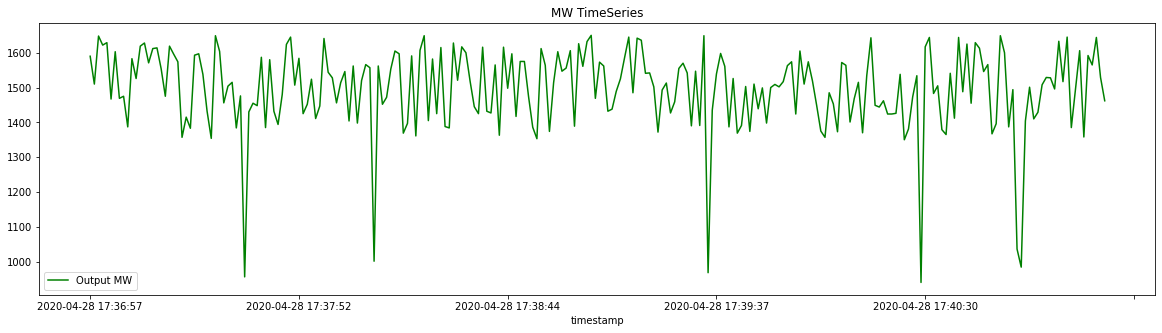

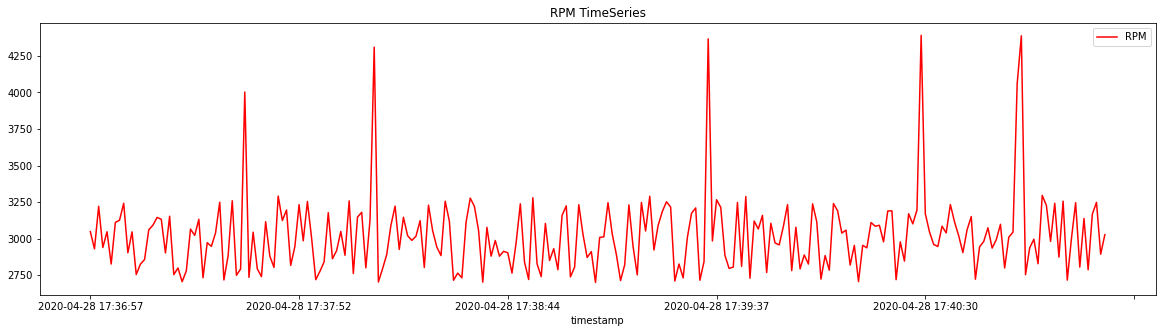

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

###########################################################################################
# Data Preparation
###########################################################################################

# Lets keep df_IotData as is, so we will never change it. All changes will happen in the new DataFrame.
# Pivoting the original data for 1 device into a new one, with one column per unit.
new_df = df_IotData[(df_IotData.deviceId == "dev-1")]
new_df=new_df.pivot(index='dateTime', columns = 'unitSymbol' , values =  'measureValue')

# Removing lines with missing data. 
new_df=new_df.dropna()

# The pivot will create a df where the dataTime column is the index. 
# But for the Anomaly detection, we need a column with that content called timestamp
new_df['timestamp']=new_df.index

# We also need a sequential id, to join the dataframes in the end of the process
new_df['index']=list(range(len(new_df)))

# Now let's make the sequential the index of the dataframe
new_df.set_index('index',inplace=True)


###########################################################################################
# Plotting the Data
###########################################################################################
# One chart per unit.
# If you change or add the units, from now on you need to customize the code.
new_df.plot(y='MW', x= 'timestamp', color='green',figsize=(20,5), label = 'Output MW')
plt.title('MW TimeSeries')
new_df.plot(y='RPM', x= 'timestamp', color='red', figsize=(20,5), label = 'RPM')
plt.title('RPM TimeSeries')
plt.legend(loc = 'best')
plt.show()


## Step 8 - Anomaly Detection

The chart above are very clear about the outliers. But can we predict them? Are there variation margins? Let's use AI to do it, leveraging the [Microsoft Azure Anomaly Detector API](https://docs.microsoft.com/en-us/azure/cognitive-services/anomaly-detector/quickstarts/detect-data-anomalies-python?tabs=linux).

&nbsp;

You must have a [Cognitive Services API account](https://docs.microsoft.com/en-us/azure/cognitive-services/cognitive-services-apis-create-account?tabs=multiservice%2Clinux) with access to the Anomaly Detector API. You can get your subscription key from the Azure portal after creating your account.

&nbsp;

The API accepts json files with 2 elements, ```timestamp``` and ```value```. These names are mandatory, and we can't mix the units for detection. That's why we create 2 customized DataFrames in the code below, right before the Anomaly Detection execution, one for each unit. Also, we should avoid mixing devices in the same analysis, since they may have different behavior.

&nbsp;

The output includes, for each unit, the expected value, the lower and upper margin values, and if it was an anomaly or not. With the margins, you can monitor in real time if a value is getting close to the margins.

&nbsp;

**DON'T FORGET TO ADD YOUR ANOMALY DETECTOR API KEY TO THE CODE BELOW!! JUST SEARCH FOR 'paste-your-key-here' AND REPLACE THE TEXT WITH YOUR KEY, THAT YOU CAN GET/COPY FROM THE AZURE PORTAL.**

&nbsp;

>**Did you know?** Anomaly Detector API has 2 endpoints, for 2 different capabilities: Real time and Batch detection. Real time will detect anomalies for every 10 data points. The Batch module will analyze up to 8046 datapoints, and since we already have the data, that's what we will use.

&nbsp;

>**Did you know?** An Azure Cognitive Services account gives you access to multiple cognitive services like Text Analytics and Computer Vision APIs.

&nbsp;

>**Did you know?** "Secondly" granularity is not documented yet, but it works and that's exactly what we need for this analysis. Also, the API limit is 8046 datapoints, but we will submit only 1000. 


## Step 9 - Creating the Anomaly Detection Function

**PLEASE ADD YOUR ANOMALY DETECTOR KEY - LINE 10**

In [22]:
import http.client, urllib.request, urllib.parse, urllib.error, base64

###########################################################################################
# The Anomaly Detection Function
###########################################################################################
def anomalyDetector (myJson):
    headers = {
        # Request headers
        'Content-Type': 'application/json',
        'Ocp-Apim-Subscription-Key': 'your-key-here', # <<---- Paste your key here!!!!
    }

    params = urllib.parse.urlencode({
    })
   
    
    try:
        conn = http.client.HTTPSConnection('westus2.api.cognitive.microsoft.com')
        conn.request("POST", "/anomalydetector/v1.0/timeseries/entire/detect?%s" % params, myJson, headers)
        response = conn.getresponse()
        data = response.read()
        return(data)
        conn.close()
    except Exception as e:
        print("[Errno {0}] {1}".format(e.errno, e.strerror))
 

print ('Function anomalyDetector() ok')

Function anomalyDetector() ok


## Step 10 - Detecting Anomalies

This step will submit the data of each device to the batch endpoint of the API. It also requires some data preparation. **We need to:**

&nbsp;

1. Format the json file that is submitted to the API, separating the data of each unit and each device.
1. Create a new DataFrame with the most granular results for each device and each unit, in the API required format.
1. Accumulate all temporary data in an output DataFrame.
1. Clean missing data again.
1. Transform the lower and upper margins in values for plotting.


In [23]:
###########################################################################################
# The main funciton, that will process per device
###########################################################################################

# Let's use the same DataFrame of the first analysis to get data the devices ids.
devicesArray = df_IotData.deviceId.unique()

# Creating Output dataframe
output_df = pd.DataFrame()

# Let's process per device
for deviceId in devicesArray:
    print ('Processing device: ',deviceId)
    
    # Same data preparation we had for data visualization, but for each device.
    new_df = df_IotData[(df_IotData.deviceId == deviceId)]
    # The pivot below will remove deviceId column. We will add it back later.
    new_df=new_df.pivot(index='dateTime', columns = 'unitSymbol' , values =  'measureValue')
    new_df=new_df.dropna()
    
    # The pivot will create a df where the dataTime column is the index. 
    # But for the Anomaly detection, we need a column with that content called timestamp
    new_df['timestamp']=new_df.index

    # We also need a sequential id, to join the dataframes in the end of the process
    new_df['index']=list(range(len(new_df)))

    # Now let's make the sequential the index of the dataframe
    new_df.set_index('index',inplace=True)

    #### RPM
    # Creating a DataFrame in the API format. We need a timestamp and a value columns
    new_df_RPM=new_df[['timestamp','RPM']]
    new_df_RPM.rename(columns={"RPM":"value"},inplace=True)
    # Creating json string
    myJson= '{"granularity":"secondly","series": '
    myJson = myJson+ new_df_RPM.to_json(orient = 'records')+'}'
    # Running and saving the results in a new dataframe
    rpmAnomalies= anomalyDetector (myJson)
    new_df_RPM_results = pd.read_json(rpmAnomalies)
    
    ### MW
    # Creating a DataFrame in the API format. We need a timestamp and a value columns
    new_df_MW=new_df[['timestamp','MW']]
    new_df_MW.rename(columns={"MW":"value"},inplace=True)
    # Creating json string
    myJson= '{"granularity":"secondly","series": '
    myJson = myJson+ new_df_RPM.to_json(orient = 'records')+'}'
    # Running and saving the results in a new dataframe
    mwAnomalies= anomalyDetector (myJson)
    new_df_MW_results = pd.read_json(mwAnomalies)

    # Checking the results. Number of rows should be exactly the same.
    rpmCount = new_df_RPM_results.shape[0]  # gives number of row count
    mwCount = new_df_MW_results.shape[0]  # gives number of row count
    
    if (rpmCount != mwCount):
        print('Something went wrong, total rows in the results should be the same.')
        print ('rpmCount: ',rpmCount)
        print ('mwCount: ',mwCount)
    else:
        # Preparing the margin values for plotting
        new_df_RPM_results['lowerMargins'] = new_df_RPM_results['expectedValues'] - new_df_RPM_results['lowerMargins']
        new_df_RPM_results['upperMargins'] = new_df_RPM_results['expectedValues'] + new_df_RPM_results['upperMargins']
        new_df_MW_results['lowerMargins'] = new_df_MW_results['expectedValues'] - new_df_MW_results['lowerMargins']
        new_df_MW_results['upperMargins'] = new_df_MW_results['expectedValues'] + new_df_MW_results['upperMargins']
        # Merging original (we need the timestamp/datetime) + results
        new_df_RPM = new_df_RPM.join(new_df_RPM_results,lsuffix='Original',rsuffix='Results')
        new_df_MW = new_df_MW.join(new_df_MW_results,lsuffix='Original',rsuffix='Results')
        # Merging in temp DataFrame just to add the deviceId
        temp_df = new_df_RPM.join(new_df_MW,lsuffix='RPM',rsuffix='MW')
        temp_df['deviceId'] = deviceId
        if (output_df.size == 0): #First execution
            output_df = temp_df
        else:
            output_df = output_df.append(temp_df)
    print ('Rows processed: ',mwCount,' for device ',deviceId)    



Processing device:  dev-1
Rows processed:  244  for device  dev-1
Processing device:  dev-2
Rows processed:  249  for device  dev-2


## Step 11 - Anomalies Visualization

Now let's use the built-in visualizations to analyze the data. The suggestion is to test all options, so you can analyze all data we created using data preparation and AI.

&nbsp;


>**Did you know?** All resulted properties from the Anomaly Detector API are listed [here](https://docs.microsoft.com/en-us/dotnet/api/microsoft.azure.cognitiveservices.anomalydetector.models.entiredetectresponse?view=azure-dotnet-preview). You may want to check this information to create better visualizations.

### Final Data Visualization

You should be able to see interesting line charts, like this image below. Compare all 4 coluns for each unit separated, that't why we pivoted the data. Please notice that in many situations the original value is beyond the margins. The expected value is the base line and you can also check how it compares with the original value.

&nbsp;

<img src="https://cosmosnotebooksdata.blob.core.windows.net/notebookdata/iot-ai-notebook-3.PNG" alt="Built-in nteract " width="100%"/>


In [24]:
output_df.head(50)


,timestampRPM,valueRPM,expectedValuesRPM,isAnomalyRPM,isNegativeAnomalyRPM,isPositiveAnomalyRPM,lowerMarginsRPM,periodRPM,upperMarginsRPM,timestampMW,valueMW,expectedValuesMW,isAnomalyMW,isNegativeAnomalyMW,isPositiveAnomalyMW,lowerMarginsMW,periodMW,upperMarginsMW,deviceId
index,,,,,,,,,,,,,,,,,,,
0,2020-04-28 17:36:57,3048.0,3048.000000,False,False,False,3042.380000,0,3053.620000,2020-04-28 17:36:57,1590.0,3048.000000,False,False,False,3042.380000,0,3053.620000,dev-1
1,2020-04-28 17:36:58,2930.0,2989.000000,False,False,False,2929.410000,0,3048.590000,2020-04-28 17:36:58,1510.0,2989.000000,False,False,False,2929.410000,0,3048.590000,dev-1
2,2020-04-28 17:36:59,3221.0,2969.333333,False,False,False,2715.150000,0,3223.516667,2020-04-28 17:36:59,1648.0,2969.333333,False,False,False,2715.150000,0,3223.516667,dev-1
3,2020-04-28 17:37:00,2939.0,2961.750000,False,False,False,2938.772500,0,2984.727500,2020-04-28 17:37:00,1622.0,2961.750000,False,False,False,2938.772500,0,2984.727500,dev-1
4,2020-04-28 17:37:01,3047.0,2978.800000,False,False,False,2909.918000,0,3047.682000,2020-04-28 17:37:01,1629.0,2978.800000,False,False,False,2909.918000,0,3047.682000,dev-1
5,2020-04-28 17:37:02,2826.0,2934.400000,False,False,False,2824.916000,0,3043.884000,2020-04-28 17:37:02,1467.0,2934.400000,False,False,False,2824.916000,0,3043.884000,dev-1
6,2020-04-28 17:37:03,3111.0,2970.600000,False,False,False,2828.796000,0,3112.404000,2020-04-28 17:37:03,1603.0,2970.600000,False,False,False,2828.796000,0,3112.404000,dev-1
7,2020-04-28 17:37:04,3126.0,3009.800000,False,False,False,2892.438000,0,3127.162000,2020-04-28 17:37:04,1469.0,3009.800000,False,False,False,2892.438000,0,3127.162000,dev-1
8,2020-04-28 17:37:05,3242.0,3070.400000,False,False,False,2897.084000,0,3243.716000,2020-04-28 17:37:05,1475.0,3070.400000,False,False,False,2897.084000,0,3243.716000,dev-1


## Step 12 - Loading the Anomalies into Azure Cosmos DB

Now let's load the results into Azure Cosmos Db. **But Why?** For two reasons:

&nbsp;

1. **Metadata:** Now we have the expected values, per device and per unit: the values between the lower and the upper margins. You can read from Azure Cosmos DB and detect anomalies in real time or in batch. This method is cheaper and faster than using the Anomaly Detector API for every single datapoint. The API should be used from time to time to refresh the metadata because of seasonality and other factors. The API also can be used to cross validate the anomalies detected.

&nbsp;

2. **Advanced Analytics/AI:** This data can be queried not only from Azure Cosmos DB transactional store, but also from our brand new [Analitical Store](https://azure.microsoft.com/en-us/updates/new-analytics-storage-for-azure-cosmos-db-is-now-in-preview/). You can use both for PBI reports, more Machine Learning analysis, predictions, etc.

&nbsp;

>**Did you know?** Azure Cosmos DB guarantees less than 10-ms latencies for reads and writes at the 99th percentile, all around the world. [Learn more](https://docs.microsoft.com/en-us/azure/cosmos-db/introduction#guaranteed-low-latency-at-99th-percentile-worldwide).


**THIS FUNCTION DOESN'T TEST IF THE SAME DATA WAS UPLOADED BEFORE.**

In [25]:
###########################################################################################
# Loading the Data into Azure Cosmos DB
###########################################################################################

#  Initialization
db_name = "CosmosAnalyticsDemoDb"
container_name = "IotAnomalies"
partition_key_value = "/deviceId" #Thinking that in the future you will have multiple devices.Also, data will probably analyzed per device.

# Key Objects Creation

database_client = cosmos_client.create_database_if_not_exists(db_name)
print(database_client, 'ok')

container_client = database_client.create_container_if_not_exists(id=container_name, partition_key=PartitionKey(path=partition_key_value),offer_throughput=400)
print(container_client, 'ok')

for i in range(0, len(output_df)):
    
    if (i % 10 == 0 ) and (i > 0): #let's report the progress for each 10 docs uploaded
        print ('Number of docs uploaded: ', i)
   
    adMetaData = {
    'id' : str(uuid.uuid4()),
    'deviceId' :output_df.iloc[i]['deviceId'], 
    'timestamp' : output_df.iloc[i]['timestampRPM'], #Doesn't matter, for this column RPM = MW
    'originalMWValue' : int(output_df.iloc[i]['valueMW']),
    'expectedValuesMW' : int(output_df.iloc[i]['expectedValuesMW']), # Keeping 'values', plural as the original name.
    'output_df' : str(output_df.iloc[i]['isAnomalyMW']).lower(),
    'isNegativeAnomalyMW' : str(output_df.iloc[i]['isNegativeAnomalyMW']).lower(),
    'isPositiveAnomalyMW' : str(output_df.iloc[i]['isPositiveAnomalyMW']).lower(),
    'lowerMarginsMW' : int(output_df.iloc[i]['lowerMarginsMW']),
    'upperMarginsMW' : int(output_df.iloc[i]['upperMarginsMW']),
    'periodMW' : int(output_df.iloc[i]['periodMW']),
    'originalRPMValue' : output_df.iloc[i]['valueRPM'],
    'expectedValuesRPM' : output_df.iloc[i]['expectedValuesRPM'], # Keeping 'values', plural as the original name.
    'isAnomalyRPM' : str(output_df.iloc[i]['isAnomalyRPM']).lower(),
    'isNegativeAnomalyRPM' : str(output_df.iloc[i]['isNegativeAnomalyRPM']).lower(),
    'isPositiveAnomalyRPM' : str(output_df.iloc[i]['isPositiveAnomalyRPM']).lower(),
    'lowerMarginsRPM' : int(output_df.iloc[i]['lowerMarginsRPM']),
    'upperMarginsRPM' : int(output_df.iloc[i]['upperMarginsRPM']),
    'periodRPM' : int(output_df.iloc[i]['periodRPM'])
    }
    container_client.create_item(body=adMetaData)

<DatabaseProxy [dbs/CosmosAnalyticsDemoDb]> ok
<ContainerProxy [dbs/CosmosAnalyticsDemoDb/colls/IotAnomalies]> ok
Number of docs uploaded:  10
Number of docs uploaded:  20
Number of docs uploaded:  30
Number of docs uploaded:  40
Number of docs uploaded:  50
Number of docs uploaded:  60
Number of docs uploaded:  70
Number of docs uploaded:  80
Number of docs uploaded:  90
Number of docs uploaded:  100
Number of docs uploaded:  110
Number of docs uploaded:  120
Number of docs uploaded:  130
Number of docs uploaded:  140
Number of docs uploaded:  150
Number of docs uploaded:  160
Number of docs uploaded:  170
Number of docs uploaded:  180
Number of docs uploaded:  190
Number of docs uploaded:  200
Number of docs uploaded:  210
Number of docs uploaded:  220
Number of docs uploaded:  230
Number of docs uploaded:  240
Number of docs uploaded:  250
Number of docs uploaded:  260
Number of docs uploaded:  270
Number of docs uploaded:  280
Number of docs uploaded:  290
Number of docs uploaded: 

## Step 13 - Checking the Anomalies Container

Let's check the documents we uploaded to the container.

In [28]:
%container IotAnomalies

In [29]:
%database CosmosAnalyticsDemoDb

In [26]:
%%sql 
SELECT count(1) FROM c 

▶ View Query Metrics 
 
 
 
 totalExecutionTimeInMs : 0.61 queryCompileTimeInMs : 0.12 queryLogicalPlanBuildTimeInMs : 0.04 queryPhysicalPlanBuildTimeInMs : 0.05 queryOptimizationTimeInMs : 0 VMExecutionTimeInMs : 0.21 indexLookupTimeInMs : 0.19 documentLoadTimeInMs : 0 systemFunctionExecuteTimeInMs : 0 userFunctionExecuteTimeInMs : 0 retrievedDocumentCount : 0 retrievedDocumentSize : 0 outputDocumentCount : 1 outputDocumentSize : 81 writeOutputTimeInMs : 0 averageIndexUtilizationRation : 1

,$1
0,1978


In [27]:
%%sql 
SELECT c.timestamp, c.deviceId, c.isAnomalyRPM,c.originalRPMValue, c.expectedValuesRPM FROM c where  c.isAnomalyRPM = "true" 

▶ View Query Metrics 
 
 
 
 totalExecutionTimeInMs : 2.98 queryCompileTimeInMs : 0.12 queryLogicalPlanBuildTimeInMs : 0.04 queryPhysicalPlanBuildTimeInMs : 0.07 queryOptimizationTimeInMs : 0 VMExecutionTimeInMs : 2.5 indexLookupTimeInMs : 0.35 documentLoadTimeInMs : 1.68 systemFunctionExecuteTimeInMs : 0 userFunctionExecuteTimeInMs : 0 retrievedDocumentCount : 32 retrievedDocumentSize : 22287 outputDocumentCount : 32 outputDocumentSize : 4512 writeOutputTimeInMs : 0.2 averageIndexUtilizationRation : 1

,timestamp,deviceId,isAnomalyRPM,originalRPMValue,expectedValuesRPM
0,2020-04-17 18:03:07,dev-1,true,4156,2857.814286
1,2020-04-17 18:04:34,dev-1,true,4223,3050.044444
2,2020-04-17 18:05:41,dev-1,true,3941,3054.284706
3,2020-04-17 18:06:07,dev-1,true,4091,2936.756250
4,2020-04-17 18:03:07,dev-2,true,3906,2910.157143
5,2020-04-17 18:04:34,dev-2,true,4070,3040.328302
6,2020-04-17 18:05:41,dev-2,true,3979,2966.711905
7,2020-04-17 18:06:07,dev-2,true,4009,2968.035417
8,2020-04-17 18:03:07,dev-1,true,4156,2857.814286
9,2020-04-17 18:04:34,dev-1,true,4223,3050.044444


## Next Steps

Suggested next steps are:

+ Use Power BI to [create dashboards](https://docs.microsoft.com/en-us/azure/cosmos-db/powerbi-visualize) on with BOTH containers data we created. Their combination is very powerful.
+ Try our other Sample Notebooks.
+ Send us your feedback or contribution in our [GitHub repo](https://github.com/Azure-Samples/cosmos-notebooks).